In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
!pip install yfinance
!pip install pyts
!pip install --upgrade mplfinance

--2024-01-18 13:10:06--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-01-18 13:10:07--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-01-18 13:10:07--  http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving phoenixna

# 經濟情勢分析

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import talib
import yfinance as yf
import mplfinance as mpf

def summary(index, sensitivity = 90):
  for i in index:
    index[i]['MEAN'] = talib.SMA(index[i].Close, timeperiod=sensitivity)
    index[i]['STD'] = talib.STDDEV(index[i].Close, timeperiod=sensitivity)
    index[i]['HCL0'] = np.where(index[i]['Low'] > (index[i]['MEAN'] + 1 * index[i]['STD']), 1, 0)
    index[i]['HCL1'] = np.where(index[i]['Low'] > (index[i]['MEAN'] + 2 * index[i]['STD']), 1, 0)
    index[i]['HCL2'] = np.where(index[i]['Low'] > (index[i]['MEAN'] + 3 * index[i]['STD']), 1, 0)
    index[i]['LCL0'] = np.where(index[i]['High'] < (index[i]['MEAN'] - 1 * index[i]['STD']), 1, 0)
    index[i]['LCL1'] = np.where(index[i]['High'] < (index[i]['MEAN'] - 2 * index[i]['STD']), 1, 0)
    index[i]['LCL2'] = np.where(index[i]['High'] < (index[i]['MEAN'] - 3 * index[i]['STD']), 1, 0)
    index[i]['STATE'] = index[i]['HCL0'] + index[i]['HCL1'] + index[i]['HCL2'] - index[i]['LCL0'] - index[i]['LCL1'] - index[i]['LCL2']
    index[i].index = index[i].index.date
  df = index[list(index.keys())[-1]].copy()
  for i in index:
    df[i] = index[i].STATE
  return df

<Axes: >

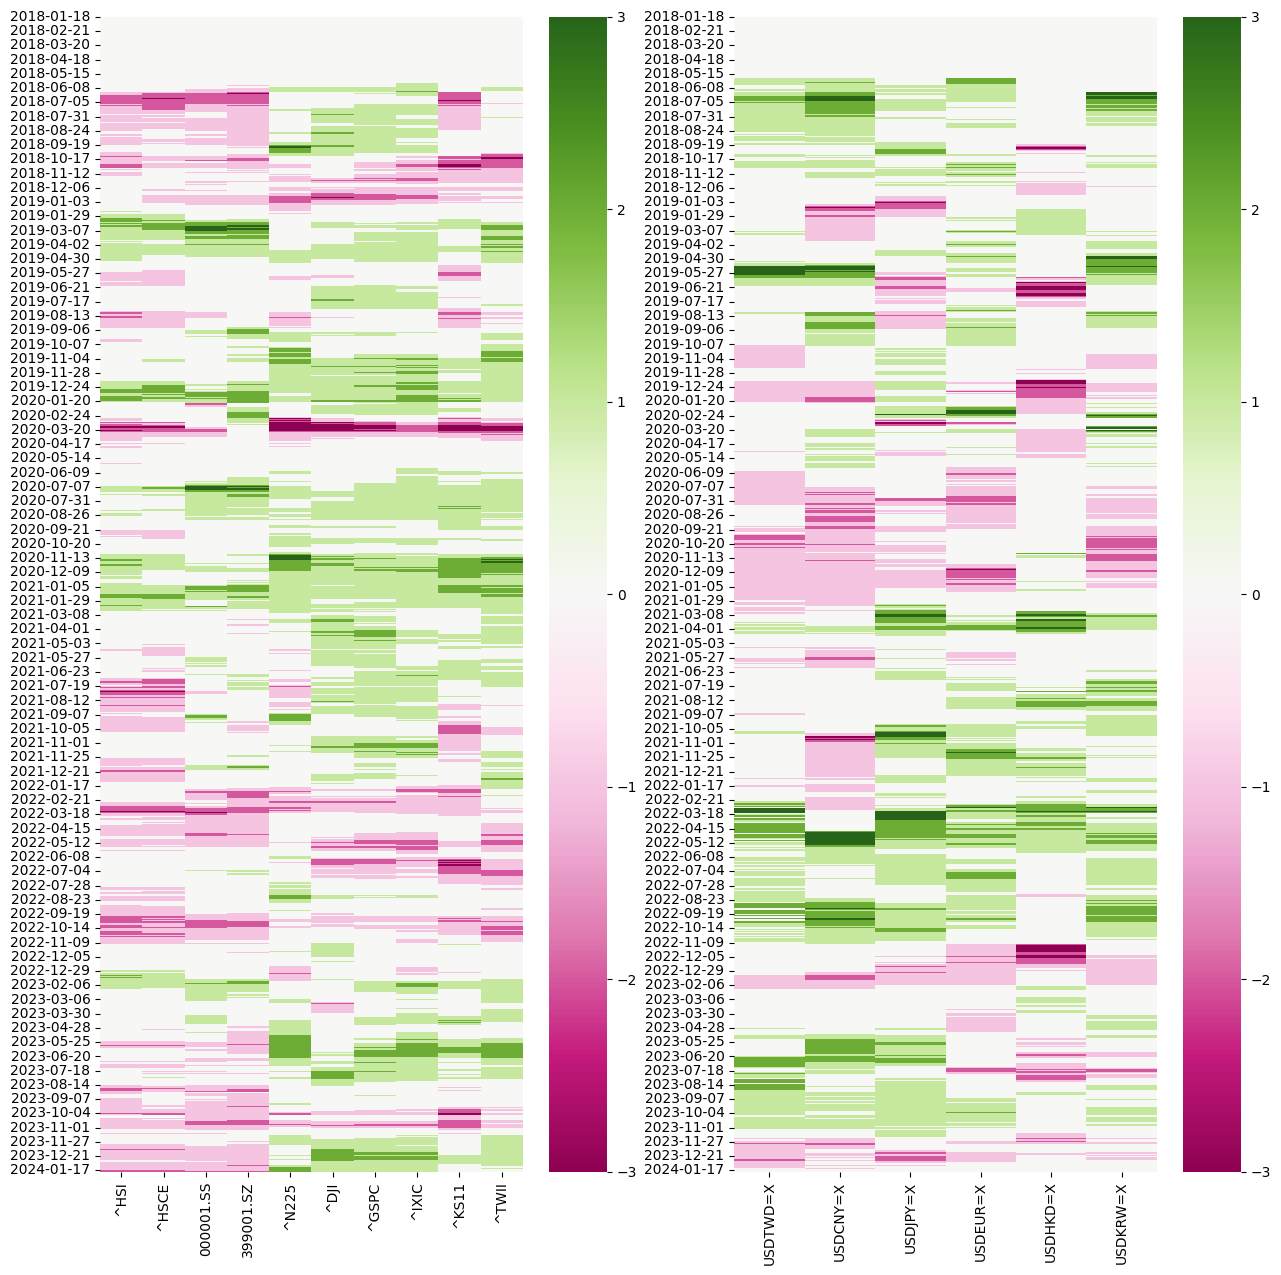

In [ ]:
market = {}
for i in ['^HSI', '^HSCE', '000001.SS', '399001.SZ', '^N225', '^DJI', '^GSPC', '^IXIC', '^KS11', '^TWII']:
  market[i] = yf.Ticker(i).history(period='6y')
market_df = summary(market)

forex = {}
for i in ['USDTWD=X', 'USDCNY=X', 'USDJPY=X', 'USDEUR=X', 'USDHKD=X', 'USDKRW=X']:
  forex[i] = yf.Ticker(i).history(period='6y')
forex_df = summary(forex)

summary_df = market_df.iloc[:, 16:].copy()
for i in forex_df.iloc[:, 16:]:
  summary_df[i] = forex_df[i]
for i in summary_df:
  summary_df[i] = summary_df[i].ffill()
plt.figure(figsize=[15, 15]); ax1 = plt.subplot(121); ax2 = plt.subplot(122)
sns.heatmap(summary_df.iloc[:, :10], cmap="PiYG", ax=ax1)
sns.heatmap(summary_df.iloc[:, 10:], cmap="PiYG", ax=ax2)

#### 1. 多空比率

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pandas as pd

def tanh(x):
  x = x
  return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

history, indexes = [], []
for i in range(90, 0, -1):
  temp_df = summary_df.iloc[: -i, :].dropna().copy()
  col = ['^DJI', '^GSPC', '^IXIC', '^TWII']
  X, y, pred_X = np.array(temp_df.iloc[: -1, :]), np.array(temp_df.loc[:, col][1: ]), np.array(temp_df.iloc[-1:, :])
  model = LinearRegression().fit(X, y)
  indexes.append(list(temp_df.index)[-1])
  history.append(model.predict(pred_X)[0])
summary = pd.DataFrame(np.array(history), columns=col).apply(tanh)
summary['indexes'] = indexes
summary = summary.set_index('indexes')
summary['^TW'] = summary['^TWII']
summary['^US'] = (summary['^DJI'] + summary['^GSPC'] + summary['^IXIC'])/3
summary = summary.loc[:, ["^TW", "^US"]]
summary

,^TW,^US
indexes,,
2023-09-08,-0.106277,0.003262
2023-09-11,-0.078360,-0.001552
2023-09-12,-0.084941,0.000834
2023-09-13,-0.085571,-0.000843
2023-09-14,-0.065201,0.007425
...,...,...
2024-01-11,0.150849,0.748538
2024-01-12,0.137209,0.751903
2024-01-15,0.717631,0.761571


# 投資組合分析
### 經營方案與管理對策
貸款條件、利率，績效衡量方式，風險評估與驗證。待車貸結清+完善技術後，再透過中信增貸

▶️ (-7%)信用貸款含手續費之年利率<br>
▶️ (95%)工作產業投資組合<br>
▶️ (5%)選擇權避險

## [GraphDB Instance](https://console.neo4j.io/?product=aura-db)

* **Username**: neo4j
* **passward**: ZzZ6zeBZ1N7fB_UAHezzHY0LajAXj2z7tmI2HwHPWa8

In [ ]:
!pip install neo4j
from neo4j import GraphDatabase
import json

AURA_CONNECTION_URI = "neo4j+s://6d2f5b5d.databases.neo4j.io"
AURA_USERNAME = "neo4j"
AURA_PASSWORD = "ZzZ6zeBZ1N7fB_UAHezzHY0LajAXj2z7tmI2HwHPWa8"
driver = GraphDatabase.driver(AURA_CONNECTION_URI, auth=(AURA_USERNAME, AURA_PASSWORD))

#### 1. 金融分析

In [ ]:
#利率因子
LOAN_INTEREST_PER_TWD = 0.07

In [ ]:
#匯率因子
import scipy.stats as stats

def forex_risk_test(x, y):
  MEAN, STD = np.mean(x), np.std(x)
  LCL, HCL = (MEAN - STD * 2), (MEAN + STD * 2)
  _, double_p = stats.ttest_ind(np.random.normal(loc=MEAN, scale=STD * MEAN, size=len(TWD.Close)), x * (y / MEAN), equal_var = False)
  if np.mean(x) > np.mean(y):
    p = double_p/2.
  else:
    p = 1.0 - double_p/2.
  return -(HCL / MEAN - 1) * round(p, 2)

EUR, TWD, KRW = yf.Ticker("EUR=X").history(period='6y'), yf.Ticker("TWD=X").history(period='6y'), yf.Ticker("KRW=X").history(period='6y')
FOREX_RISK_PER_USD = forex_risk_test(TWD.Close, TWD.Close[-1]) / 2
EUR_Close = (TWD.Close / EUR.Close).dropna()
FOREX_RISK_PER_EUR = forex_risk_test(EUR_Close, EUR_Close[-1]) / 2
KRW_Close = (TWD.Close / KRW.Close).dropna()
FOREX_RISK_PER_KRW = forex_risk_test(KRW.Close, KRW.Close[-1]) / 2
print('以美金本位之報酬效益：', round(FOREX_RISK_PER_USD * 100, 2), '%')
print('以歐元本位之報酬效益：', round(FOREX_RISK_PER_EUR * 100, 2), '%')
print('以韓元本位之報酬效益：', round(FOREX_RISK_PER_KRW * 100, 2), '%')

以美金本位之報酬效益： -4.17 %
以歐元本位之報酬效益： -2.89 %
以韓元本位之報酬效益： -6.55 %


#### 2. 財務分析
Prompt to GPT-4:<br>

```I am looking for the most credible investment rating agencies in the world with financial market expertise and I expect to get some risk assessment indicators from some of their reports or statements, which is very important to me as I need to support my young children and elders at home who are unable to walk. Here are the investments I am looking at: Micron(MU), Samsung, TSMC(2330.TW), ASML, ARM, NVIDIA(NVDA), MediaTek(2454.TW), AMD, Intel(INTC), 2308.TW, 2356.TW, 2317.TW, 2382. TW, 6669.TW, 2376.TW, TXN, Qualcomm(QCOM), 2412.TW, Tesla(TSLA), Amazon(AMZN), Microsoft(MSFT), Meta, Apple(AAPL), NXP(NXPI), and please help me to investigate different professional organizations' evaluation of Sharp's performance according to their order. Please follow his order to help me survey different professional organizations on their evaluation of Sharpe Indicator (as long as the Sharpe Indicator), and consolidate them into a table according to the evaluation date of this indicator. yahoo and google are not professional enough, please survey more credible organizations and give me the source of the information, so as to help me to take better care of my family.```

In [ ]:
update_time = '20240117'
sharpe_dict = {"Micron": 0.9,
        "Samsung": 0.33,
        "TSMC": 1.25,
        "ASML": 1.49,
        "ARM":0.7,
        "NVIDIA":4.69,
        "MediaTek":0.8, #2454
        "AMD":1.42,
        "Intel":0.8,
        "台達電": 0.7,  #2308
        "英業達": 0.7,  #2356
        "鴻海": 0.7,   #2317
        "廣達": 0.7,   #2382
        "緯穎": 0.7,   #6669
        "技嘉": 0.7,   #2376
        "德州儀器": 1,
        "Qualcomm": 1.1,
        "中華電": 0,   #2412
        "Tesla": 2.68,
        "Amazon": 2.54,
        "Microsoft": 1.54,
        "Meta": 4.9,
        "Apple": 1.9,
        "NXP": 1.2}
company_names = list(sharpe_dict.keys())
option = [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0 , 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
sharpe_last = [0.64, 0.71, 1.02, 1.25, 0.87, 1.18, 0.79, 0.96, 0.58, 0.69, 0.52, 0.44, 0.48, 0.46, 0.51, 0.76, 0.83, 0.41, 0.62, 0.91, 0.94, 0.88, 0.86, 0.74]
sharpe_current = list(sharpe_dict.values())
Sharpe = sharpe_current

--2024-01-18 13:41:30--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 108.177.12.138, 108.177.12.101, 108.177.12.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.12.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-01-18 13:41:30--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.31.132, 2607:f8b0:400c:c02::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.31.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  99.1MB/s    in 0.2s    

2024-01-18 13:41:34

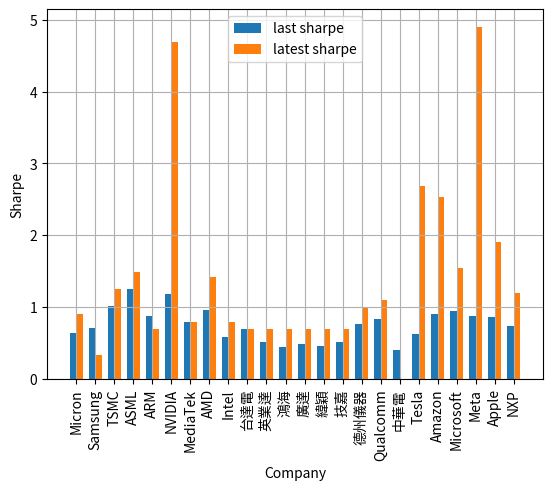

In [ ]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import warnings
import matplotlib as mpl
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')
warnings.simplefilter("ignore", UserWarning)

x = np.arange(len(company_names))
plt.bar(x, sharpe_last, width=0.35, label="last sharpe")
plt.bar(x + 0.35, sharpe_current, width=0.35, label="latest sharpe")
plt.xlabel("Company"); plt.ylabel("Sharpe"); plt.xticks(x + 0.35 / 2, company_names, rotation=90)
plt.legend(); plt.grid(); plt.show()

#### 3. 更新財務、股價資訊

In [ ]:
!pip install pyts
!pip install yahoo_fin
from prompt_toolkit.application.application import E
import yahoo_fin.stock_info as si
warnings.simplefilter('ignore', FutureWarning)

query = "MATCH (u:utility) RETURN u"
history_prices = {}

with driver.session() as session:
    results = session.run(query).data()
    for utility in results:
      print(utility['u']['name'], utility['u']['code'])
      df = yf.Ticker(utility['u']['code'])
      data = df.history(period='1y')
      if data.shape[0] > 0:
        data.index = data.index.date
        history_prices[utility['u']['name']] = data.loc[:, ['Close']]
        update, price = data.index[-1].strftime('%Y-%m-%d'), data.Close[-1]
        if update != utility['u']['update']:
        #if 1 == 1:
          quote = si.get_quote_table(utility['u']['code'])
          try:
            eps = df.income_stmt.loc['Diluted EPS', :].dropna()[0]
          except:
            eps = 0
          beta, pe_ratio = quote['Beta (5Y Monthly)'], quote['PE Ratio (TTM)']
          if utility['u']['code'].endswith('.TW'): #台幣計價
            price /= TWD.Close[-1]; eps /= TWD.Close[-1]
          elif utility['u']['code'].endswith('.TI'): #歐元計價
            price /= EUR.Close[-1]; eps /= EUR.Close[-1]
            beta = beta - FOREX_RISK_PER_EUR
          elif utility['u']['code'].endswith('.KS'): #韓元計價
            price /= KRW.Close[-1]; eps /= KRW.Close[-1]
            beta = beta - FOREX_RISK_PER_KRW
          else: #美金計價
            beta = beta - FOREX_RISK_PER_USD
          price, eps = round(price, 2), round(eps, 2)

          query = "MATCH (u:utility WHERE u.name='{name}') set u.update='{update}' set u.price='{price}' set u.eps='{eps}' set u.beta='{beta}' set u.pe_ratio='{pe_ratio}'".format(name=utility['u']['name'], update=update, price=str(price), eps=eps, beta=beta, pe_ratio=pe_ratio)
          session.run(query); print(query)

Micron MU
Samsung 005930.KS
TSMC 2330.TW
ASML ASML
ARM ARM
NVIDIA NVDA
MediaTek 2454.TW
AMD AMD
Intel INTC
SIEMENS SIE.TI


ERROR:yfinance:SIE.TI: No data found, symbol may be delisted


台達電 2308.TW
英業達 2356.TW
鴻海 2317.TW
廣達 2382.TW
緯穎 6669.TW
技嘉 2376.TW
德州儀器 TXN
Qualcomm QCOM
中華電 2412.TW
Tesla TSLA
Amazon AMZN
Microsoft MSFT
Meta META
Apple AAPL
NXP NXPI


#### 4. 資金部位最佳化
統整數據並下載`results.xlsx`記錄檔進行動態規劃，相關配置如下：<br>
$$\max　Z_{1}=X·R_{Sharpe}$$
$$
\text{s.t.}　　　　　　　　　　　　　　　　　　　　　　　 \\
\sum X \leq 1 \\
\sum X·R_{Beta} \leq 1 \\
X \geq 0
$$

In [ ]:
from scipy.optimize import linprog

Sharpe_temp = Sharpe.copy()
table = {'name':[], 'price': [], 'eps': [], 'BETA': [], 'PE_ratio': []}
query = "MATCH (u:utility) RETURN u"
with driver.session() as session:
  results = session.run(query).data()
  for utility in results:
    if 'eps' in utility['u'].keys():
      i = np.where(np.array(company_names)==str(utility['u']['name']))[0][0]
      if utility['u']['code'].endswith('.TW'): #台幣計價
        Sharpe_temp[i] -= LOAN_INTEREST_PER_TWD * (1 - FOREX_RISK_PER_USD)
      elif utility['u']['code'].endswith('.TI'): #歐元計價
        Sharpe_temp[i] -= LOAN_INTEREST_PER_TWD * (1 - FOREX_RISK_PER_EUR)
      elif utility['u']['code'].endswith('.KS'): #韓元計價
        Sharpe_temp[i] -= LOAN_INTEREST_PER_TWD * (1 - FOREX_RISK_PER_KRW)
      else: #美金計價
        Sharpe_temp[i] -= LOAN_INTEREST_PER_TWD
      table['name'].append(utility['u']['name']); table['price'].append(utility['u']['price']); table['eps'].append(utility['u']['eps'])
      table['BETA'].append(utility['u']['beta']); table['PE_ratio'].append(utility['u']['pe_ratio'])

table['name'].append('USD=X'); table['price'].append(TWD.Close[-1]); table['eps'].append(0); table['BETA'].append(-FOREX_RISK_PER_USD); table['PE_ratio'].append(1); Sharpe_temp.append(1 - LOAN_INTEREST_PER_TWD * (1 - FOREX_RISK_PER_USD))
table['name'].append('EUR=X'); table['price'].append(EUR.Close[-1]); table['eps'].append(0); table['BETA'].append(-FOREX_RISK_PER_EUR); table['PE_ratio'].append(1); Sharpe_temp.append(1 - LOAN_INTEREST_PER_TWD * (1 - FOREX_RISK_PER_EUR))
table['name'].append('KRW=X'); table['price'].append(KRW.Close[-1]); table['eps'].append(0); table['BETA'].append(-FOREX_RISK_PER_KRW); table['PE_ratio'].append(1); Sharpe_temp.append(1 - LOAN_INTEREST_PER_TWD * (1 - FOREX_RISK_PER_KRW))
table['name'].append('TWD=X'); table['price'].append(1); table['eps'].append(0); table['BETA'].append(0); table['PE_ratio'].append(1); Sharpe_temp.append(1 - LOAN_INTEREST_PER_TWD)

df = pd.DataFrame(table)
df['eps'], df['price'] = df['eps'].astype(float), df['price'].astype(float)
df['投資報酬率(%)/年'] = (df['eps'].astype(float) * 100 / df['price']).round(2)
df['Sharpe'] = Sharpe_temp
df['option'] = option + [1, 1, 1, 1]

df['PE_ratio'] = df['PE_ratio'].replace('nan', np.mean(df['PE_ratio'][9:23].astype(float).dropna())).astype(float)
df['BETA'] = df['BETA'].replace('nan', np.mean(df['BETA'].astype(float).dropna())).astype(float)

df["X"] = linprog(c=list(df['Sharpe'] * -1), A_ub=[list(df['BETA']), [1 for _ in range(df.shape[0])]], b_ub=[1.05, 1], bounds=[(0, 1) for _ in range(df.shape[0])], method="highs").x
df["X'"] = linprog(c=list(df['Sharpe']), A_ub=[list(df['option']), list(df['BETA'] * -1), [1 for _ in range(df.shape[0])]], b_ub=[0, -1.05, 1], bounds=[(0, 1) for _ in range(df.shape[0])], method="highs").x
df["X'"] = df["X'"] * -1
df.to_excel(update_time + '.xlsx')
temp_df = df.iloc[:24, :].copy()
#future = temp_df.iloc[np.nonzero(np.array(temp_df['X']).T)[0], :].loc[:, ["name", "X"]].to_dict('index')
#future = {future[i]['name']: future[i]['X'] for i in future}
#hedge = temp_df.iloc[np.nonzero(np.array(temp_df["X'"]).T)[0], :].loc[:, ["name", "X'"]].to_dict('index')
#hedge = {hedge[i]['name']: hedge[i]["X'"] for i in hedge}
df

,name,price,eps,BETA,PE_ratio,投資報酬率(%)/年,Sharpe,option,X,X'
0,Micron,82.850000,-5.34,1.369064,33.102143,-6.45,0.830000,1,0.000000,-0.000000
1,Samsung,53.630000,6.03,1.021081,33.102143,11.24,0.255415,1,0.000000,0.000000
2,TSMC,18.670000,1.22,1.180000,17.480000,6.53,1.177080,0,0.000000,-0.000000
3,ASML,701.700000,14.13,1.209064,33.220000,2.01,1.420000,1,0.000000,-0.000000
4,ARM,68.040000,0.51,0.970195,377.990000,0.75,0.630000,1,0.000000,-0.000000
5,NVIDIA,554.590000,1.74,1.719064,73.360000,0.31,4.620000,1,0.000000,-0.000000
6,MediaTek,28.480000,2.36,1.080000,20.450000,8.29,0.727080,0,0.000000,-0.726789
7,AMD,155.770000,0.84,1.779064,1416.090000,0.54,1.350000,1,0.000000,-0.000000
8,Intel,45.770000,1.94,1.079064,33.102143,4.24,0.730000,1,0.000000,-0.000000
9,台達電,8.790000,0.40,0.970195,22.320000,4.55,0.627080,0,0.000000,-0.273211


In [ ]:
print('美股建議投資比例', summary["^US"][-1] * 100, '%')
print('台股建議投資比例', summary["^TW"][-1] * 100, '%')
asset = 800000
portfolio_pos = {}
portfolio_neg = {}
for i, name in enumerate(df["name"][:-4]):
  option, X, X_plus = df['option'][i],df['X'][i], df["X'"][i]
  if round(X, 1) != 0:
    if option == 1:
      portfolio_pos[name] = round(summary["^US"][-1] * X, 2)
    else:
      portfolio_pos[name] = round(summary["^TW"][-1] * X, 2)
  if round(X_plus, 1) != 0:
    if option == 0 and summary["^TW"][-1] < 0:
      portfolio_neg[name] = round(summary["^TW"][-1] * X_plus, 2)

portfolio_pos, portfolio_neg

美股建議投資比例 75.82530676201034 %
台股建議投資比例 10.021331183068453 %


({'Meta': 0.61}, {})

#### 4. 健康度評估

In [ ]:
def process(option, portfolio):
  labels, columns = {}, []
  for cls in ["field", "topic", "product", "utility"]:
    query = "MATCH (n:{cls}) RETURN n".format(cls=cls)
    with driver.session() as session:
      results = session.run(query).data()
      labels[cls] = [i['n']['name'] for i in results]
      columns += labels[cls]
  transition_matrix, columns = np.zeros((len(columns), len(columns))), np.array(columns)

  level_state = np.zeros((len(columns)))
  pe_pair = []
  for utility in results:
    try:
      if utility['n']['PE_ratio'] != 'nan':
        pe_pair.append([utility['n']['name'], utility['n']['PE_ratio']])
    except:
      pass
  pe_pair = np.array(pe_pair)
  base_count = 0
  for name, pe_ratio in pe_pair:
    _, p = stats.ttest_ind(pe_pair[:,1].astype(float), [float(pe_ratio)])
    #if p > 0.05:
    if 1 == 1:
      i = np.where(columns==str(name))[0][0]
      level_state[i] = pe_ratio; base_count += 1
  level_state = np.array(level_state)/ base_count


  absorbing_node = [np.where(columns==cls)[0][0] for cls in labels[option]]
  #定義吸收節點
  for i in absorbing_node:
    transition_matrix[i][i] = 1

  #定義轉移矩陣
  query = "MATCH p=()-[:dominate]->() RETURN p"
  with driver.session() as session:
    results = session.run(query).data()
    for vertex in results:
      i, j = np.where(columns==vertex['p'][0]['name'])[0][0], np.where(columns==vertex['p'][2]['name'])[0][0]
      if i not in absorbing_node:
        transition_matrix[i][j] = 1
  for i in range(len(columns)):
    if np.sum(transition_matrix[i]) > 0:
      transition_matrix[i] /= np.sum(transition_matrix[i])

  #【投資部位】
  #定義狀態向量
  state = np.zeros((len(columns)))
  for cls in portfolio:
    i = np.where(columns==cls)[0][0]
    state[i] = portfolio[cls]

  #取得穩態機率
  for _ in range(len(columns)):
    state = state.dot(transition_matrix)
  slack = 1
  for i, j in enumerate(absorbing_node):
    slack -= state[absorbing_node][i]
    print(columns[j], ':', round(state[absorbing_node][i] * 100, 2), '%')
  print('Cash :', round(slack * 100, 2), '%')
  #【市場水位】
  for _ in range(len(columns)):
    level_state = level_state.dot(transition_matrix)
  print('\n市場整體本益比:', round(np.sum(level_state * state), 2))

def estimate(df, portfolio):
  beta, sharpe, pe_ratio = 0, 0, 0
  for name in portfolio:
    beta += float(df[df['name']==name]['BETA']) * portfolio[name]
    sharpe += float(df[df['name']==name]['Sharpe']) * portfolio[name]
    pe_ratio += float(df[df['name']==name]['PE_ratio']) * portfolio[name]
  print('-------------------\nBeta:', round(beta, 2), ',Sharpe Ratio:', round(sharpe, 2), ',PE Ratio:', round(pe_ratio, 2))

In [ ]:
opt = 'field' #@param ["field", "topic", "product"]
process(opt, portfolio_pos)
estimate(df, portfolio_pos)

工業自動化 : 22.0 %
醫療/車用/元宇宙 : 24.44 %
機器人 : 19.56 %
Cash : 34.0 %

市場整體本益比: 22.77
-------------------
Beta: 0.8 ,Sharpe Ratio: 1.37 ,PE Ratio: 21.93
